In [1]:
# define logging and working directory
import os
import io
import sys
import logging
import platform
# change working directory to project root - neccessary for jupyter notebooks
if platform.system() is "Windows":
    os.chdir('E:\\sven\\git\\cardio')
else:
    os.chdir('/Users/minority/Code/Git/cardio')

# define jupyter params
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# define GPU id to use
# 0 = 1080
# 1 = Titan
# 2 = Titan
gpu_id = "2"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_id
current_gpu = '/device:GPU:0'
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from ipywidgets import interact
from keras.utils import plot_model
import matplotlib.pyplot as plt
from src.visualization.visualize import show_slice_transparent, show_slice

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5582958780072827749
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11890907956
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7401471036141087741
physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:84:00.0, compute capability: 6.1"
]


In [2]:
from src.utils.utils_io import Console_and_file_logger, ensure_dir, init_config
import src.utils.my_metrics as metr
from src.models.ModelManager import create_spatial_transformer_2d_unet

In [3]:
Console_and_file_logger('Spatial_transformer')

2019-08-01 01:25:02,042 INFO -------------------- Start --------------------
2019-08-01 01:25:02,042 INFO Filename: Spatial_transformer
2019-08-01 01:25:02,042 INFO Working directory: E:\sven\git\cardio.
2019-08-01 01:25:02,042 INFO Log directory: ./logs/


# create a model with a spatial transformer in before

In [4]:
config = {}
metrics = [metr.dice_coef_labels]
model = create_spatial_transformer_2d_unet(config, metrics)

2019-07-31 22:36:11,506 INFO Transformer output shape: (?, 224, 224, ?)
2019-07-31 22:36:12,848 INFO Optimizer: Adam


In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 124, 124, 20) 520         max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 62, 62, 20)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [6]:
plot_model(model, to_file='reports/spatial_transformers_tests/model_v1.png', show_shapes=True)

In [7]:
# get all layers
layers = [layer.name for layer in model.layers if 'input' not in layer.name]
outputs = [model.get_layer(layer).output for layer in layers]

In [8]:
# define a wrapper model to get the output of all layers
from keras.models import Model
all_layers_model = Model(inputs=model.input,outputs=outputs)

In [9]:
# create a batchgenerator
# load a real image
from src.data.dataset import get_img_msk_files_from_split_dir
from src.data.generators import DataGenerator2D
images_f, masks_f = get_img_msk_files_from_split_dir('data/raw/tetra/2D/val/')
len(images_f)

batch_generator = DataGenerator2D(images_f, masks_f, config=config)
test_images = batch_generator.__getitem__(0)[0]

2019-07-31 22:36:16,545 INFO Create DataGenerator
2019-07-31 22:36:16,545 INFO No augmentation


In [10]:
# predict on original model
pred = model.predict(test_images)

In [11]:
pred.shape

(32, 224, 224, 4)

In [12]:
# predict on test images
all_layers_output = all_layers_model.predict(test_images)

In [13]:
len(all_layers_output)

49

In [15]:
for layer in all_layers_output:
    print(layer.shape)

(32, 128, 128, 1)
(32, 124, 124, 20)
(32, 62, 62, 20)
(32, 58, 58, 20)
(32, 67280)
(32, 50)
(32, 50)
(32, 6)
(32, 224, 224, 1)
(32, 224, 224, 16)
(32, 224, 224, 16)
(32, 224, 224, 16)
(32, 112, 112, 16)
(32, 112, 112, 32)
(32, 112, 112, 32)
(32, 112, 112, 32)
(32, 56, 56, 32)
(32, 56, 56, 64)
(32, 56, 56, 64)
(32, 56, 56, 64)
(32, 28, 28, 64)
(32, 28, 28, 128)
(32, 28, 28, 128)
(32, 28, 28, 128)
(32, 14, 14, 128)
(32, 14, 14, 256)
(32, 14, 14, 256)
(32, 14, 14, 256)
(32, 28, 28, 128)
(32, 28, 28, 256)
(32, 28, 28, 128)
(32, 28, 28, 128)
(32, 28, 28, 128)
(32, 56, 56, 64)
(32, 56, 56, 128)
(32, 56, 56, 64)
(32, 56, 56, 64)
(32, 56, 56, 64)
(32, 112, 112, 32)
(32, 112, 112, 64)
(32, 112, 112, 32)
(32, 112, 112, 32)
(32, 112, 112, 32)
(32, 224, 224, 16)
(32, 224, 224, 32)
(32, 224, 224, 16)
(32, 224, 224, 16)
(32, 224, 224, 16)
(32, 224, 224, 4)


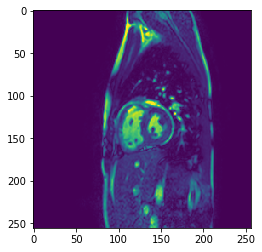

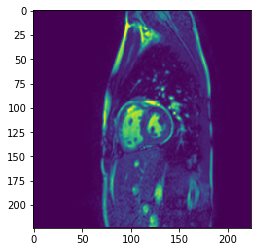

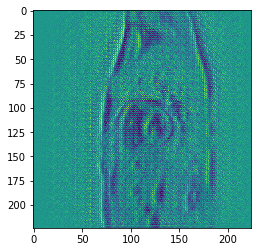

In [20]:
# input image
plt.imshow(test_images[0,:,:,0])
plt.show()

# transformed image
plt.imshow(all_layers_output[8][0][:,:,0])
plt.show()

# output image
plt.imshow(all_layers_output[-1][0][:,:,1])
plt.show()

In [21]:
# print all layers output for one image
@interact
def show_all_layers_for_one_image(img=(0,test_images.shape[0]), plot=False):
    plt.imshow(test_images[img,:,:,0])
    plt.show()
    if plot:
        #img = 0
        ncols = 10
        nrows = 5

        # create a grid
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
        axes = axes.flatten()

        # show input image
        axes[0].imshow(test_images[img,:,:,0])
        axes[0].set_title('Input image {}'.format(img))

        # show ouput image
        axes[1].imshow(show_slice(mask=pred[img,...], show=False))
        axes[1].set_title('output image {}'.format(img))

        # show output of all layers
        for layer_name, output, ax in zip(layers, all_layers_output, axes[2:]):
            if len(output.shape) == 4:
                ax.imshow(output[img,:,:,0])
                ax.set_title('layer: {} \n shape: {}'.format(layer_name, output.shape),fontsize=18, ha='center')
        plt.tight_layout()

interactive(children=(IntSlider(value=16, description='img', max=32), Checkbox(value=False, description='plot'…

# train with the spatial transformer model

In [4]:
# get data
from src.data.generators import get_samples

TRAIN_PATH = 'data/raw/tetra/2D/train'
VAL_PATH = 'data/raw/tetra/2D/val'
TEST_PATH = 'data/raw/tetra/2D/test'


# load only slices from the lower, middle or upper part, all
X_train, Y_train = get_samples(path=TRAIN_PATH, samples=0, part='all', no_patients = 0, preprocessed=False)
X_val, Y_val = get_samples(path=VAL_PATH, samples=0, part='all', no_patients = 0, preprocessed=False)
X_test, Y_test = get_samples(path=TEST_PATH, samples=0, part='all', no_patients = 0, preprocessed=False)


logging.info('train images: {}'.format(len(X_train)))
logging.info('train masks: {}'.format(len(Y_train)))
logging.info('validation images: {}'.format(len(X_val)))
logging.info('validation masks: {}'.format(len(Y_val)))
logging.info('test images: {}'.format(len(X_test)))
logging.info('test masks: {}'.format(len(Y_test)))

2019-08-01 01:25:34,853 INFO selected patients: ['0003-04NEJQUZ-2007-03-13', '0006-0AE4R74L-1900-01-01', '0007-0HQQW4ZN-2007-05-23', '0008-0PTV75MP-2005-06-27', '0010-0RPELLU8-2007-02-13', '0013-13JLP3HN-2007-05-22', '0014-1DRHF745-2005-09-01', '0016-1E4PF7MR-2006-07-06', '0018-1E8MCV9L-2005-12-15', '0034-1Y8H8XLE-2007-03-22', '0042-24YLF77L-2007-11-19', '0046-2CVUG1C5-2006-09-06', '0049-2FUH59VD-2006-08-24', '0051-2HQVK81W-2005-03-11', '0059-2WHFP73X-2007-03-28', '0066-2Y9U5LLC-2006-07-24', '0068-3E8U83K5-2006-04-01', '0070-3E90836W-2006-05-23', '0073-3EX293QC-2006-06-19', '0076-3HYXWJWW-2006-11-17', '0081-3U3KT9LV-2006-12-19', '0084-3WRWDJPC-2004-05-26', '0086-44U3AGET-2006-08-01', '0095-4A8MPQF4-2005-03-15', '0100-4HD5X727-2006-02-16', '0106-4PWV5NAX-2008-09-30', '0107-4Q0TDELR-2007-03-29', '0109-4QGENZMT-2007-02-22', '0116-5CXHN75U-2006-08-02', '0117-5JGEZLYC-2007-09-25', '0124-5T8DXCQ2-2006-10-01', '0127-5W8RFCJD-2005-04-18', '0129-5YX47QXL-2006-10-13', '0131-68UAYTYD-2005-10-01',

In [5]:
# define minimal training params
import datetime
from src.utils.utils_io import init_config, ensure_dir



now = datetime.datetime.now()

# image params
DIM = [224, 224]
IMG_WIDTH = 224
IMG_HEIGHT = 224
# Greyscale images
IMG_CHANNELS = 1
# RV = 1 = Y[...,0] 
# Myo = 2 = Y[...,1] 
# LV = 3 = Y[...,2]
MASK_VALUES = [0, 1, 2, 3]  
MASK_CLASSES = len(MASK_VALUES)
AUGMENT = False
SHUFFLE = True
SPACING_X = 1.00
SPACING_Y = 1.00
SCALER = 'MinMax'
RESAMPLE = False

# paths
EPOCHS = 150
EXPERIMENT = '2D/unet_tetra_spatial_transform'
MODEL_PATH = os.path.join(os.path.join('models', EXPERIMENT), str(now.strftime("%Y-%m-%d_%H_%M")))
TENSORBOARD_LOG_DIR = os.path.join(os.path.join('reports/tensorboard_logs', EXPERIMENT),str(now.strftime("%Y-%m-%d_%H_%M")))
CONFIG_PATH = os.path.join(os.path.join('reports/configs/',EXPERIMENT),str(now.strftime("%Y-%m-%d_%H_%M")))
HISTORY_PATH = os.path.join(os.path.join('reports/history/',EXPERIMENT),str(now.strftime("%Y-%m-%d_%H_%M")))
# training params
ARCHITECTURE = '2D'
SEED = 42
BATCHSIZE =  16 # 64, 16, 1
EPOCHS = 150
EPOCHS_BETWEEN_CHECKPOINTS = 5
MONITOR_FUNCTION = 'dice_coef_labels'
MONITOR_MODE = 'max'

# Network params
OPTIMIZER = 'Adam'  # adam, sgd, softmax # https://keras.io/optimizers/
ACTIVATION = 'elu'  # 'elu' --> works well with binary_crossentropy and bce_dice_loss, relu does not work, it clips negative values, bse does return negative values
LEARNING_RATE = 0.001
DECAY = 0.0
EPSILON = 1e-08
DROPOUT_L1_L2 = 0.4 # best with 0.4 and other 0.5
DROPOUT_L3_L4 = 0.5
DROPOUT_L5 = 0.5
BATCH_NORMALISATION = True
config = dict(((key, value) for key, value in locals().items()
               if key.isupper() and key not in ['HTML', 'K']))
metrics = [metr.bce_dice_jac_loss,
    metr.dice_coef,
    metr.dice_coef_labels,
    metr.dice_coef_background,
    metr.dice_coef_myo,
    metr.dice_coef_lv,
    metr.dice_coef_rv,]

In [6]:
# get model
model = create_spatial_transformer_2d_unet(config, metrics)

2019-08-01 01:26:20,628 INFO Optimizer: Adam


In [7]:
plot_model(model, to_file='reports/spatial_transformers_tests/model_v2.png', show_shapes=True)

In [8]:
# create datagenerators
from src.data.generators import DataGenerator2D

batch_generator = DataGenerator2D(X_train, Y_train, config=config)
validation_generator = DataGenerator2D(X_val, Y_val , config=config)
test_generator = DataGenerator2D(X_test, Y_test, config=config)

2019-08-01 01:26:24,685 INFO Create DataGenerator
2019-08-01 01:26:24,685 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 16
 Scaler: MinMax
 Images: 10342
2019-08-01 01:26:24,700 INFO No augmentation
2019-08-01 01:26:24,700 INFO Create DataGenerator
2019-08-01 01:26:24,700 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 16
 Scaler: MinMax
 Images: 1870
2019-08-01 01:26:24,700 INFO No augmentation
2019-08-01 01:26:24,700 INFO Create DataGenerator
2019-08-01 01:26:24,700 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 16
 Scaler: MinMax
 Images: 1847
2019-08-01 01:26:24,700 INFO No augmentation


In [9]:
# start training
from src.utils.KerasCallbacks import get_callbacks


initial_epoch = 0
# training

with tf.device(current_gpu):
    # fit model with trainingsgenerator
    logging.info('Fit model')
    results = model.fit_generator(
        generator=batch_generator,
        steps_per_epoch = len(batch_generator)//10,
        epochs=EPOCHS,
        callbacks=get_callbacks(config),
        validation_data=validation_generator,
        validation_steps = len(validation_generator)//10 + 1,
        initial_epoch=initial_epoch,
        max_queue_size=20,
        workers=8,
        verbose=1)

2019-08-01 01:26:24,981 INFO Fit model
2019-08-01 01:26:25,574 INFO selected patients: ['0116-5CXHN75U-2006-08-02'] from: 151
2019-08-01 01:26:25,574 INFO Create DataGenerator
2019-08-01 01:26:25,589 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 2
 Scaler: MinMax
 Images: 15
2019-08-01 01:26:25,589 INFO No augmentation
2019-08-01 01:26:25,889 INFO selected patients: ['0514-Q0QN3J15-2005-05-12'] from: 25
2019-08-01 01:26:25,904 INFO Create DataGenerator
2019-08-01 01:26:25,904 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 2
 Scaler: MinMax
 Images: 15
2019-08-01 01:26:25,904 INFO No augmentation
2019-08-01 01:26:26,591 INFO selected patients: ['0116-5CXHN75U-2006-08-02'] from: 151
2019-08-01 01:26:26,606 INFO Create DataGenerator
2019-08-01 01:26:26,606 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 2
 Scaler: MinMax
 Images: 35
2019-08-01 01:26:26,622 INFO No augmentation
2019-08-01 01:26:26,918 INFO selected patients: ['0514-Q0QN

Epoch 1/150
64/64 [==============================] - 62s 975ms/step - loss: 1.0125 - bce_dice_jac_loss: 0.6847 - dice_coef: 0.3971 - dice_coef_labels: 0.0703 - dice_coef_background: 0.6759 - dice_coef_myo: 0.0528 - dice_coef_lv: 0.0627 - dice_coef_rv: 0.0918 - val_loss: 0.7191 - val_bce_dice_jac_loss: 0.8116 - val_dice_coef: 0.4482 - val_dice_coef_labels: 0.0921 - val_dice_coef_background: 0.6950 - val_dice_coef_myo: 0.0669 - val_dice_coef_lv: 0.0769 - val_dice_coef_rv: 0.1274


2019-08-01 01:28:27,637 INFO Saved model to disk: models\2D/unet_tetra_spatial_transform\2019-08-01_01_25



Epoch 00001: dice_coef_labels improved from -inf to 0.07025, saving model to models\2D/unet_tetra_spatial_transform\2019-08-01_01_25\checkpoint.h5
Epoch 2/150
64/64 [==============================] - 31s 478ms/step - loss: 0.6406 - bce_dice_jac_loss: 0.8261 - dice_coef: 0.4814 - dice_coef_labels: 0.1007 - dice_coef_background: 0.7131 - dice_coef_myo: 0.0732 - dice_coef_lv: 0.0853 - dice_coef_rv: 0.1380 - val_loss: 0.5119 - val_bce_dice_jac_loss: 0.9276 - val_dice_coef: 0.5157 - val_dice_coef_labels: 0.1131 - val_dice_coef_background: 0.7317 - val_dice_coef_myo: 0.0837 - val_dice_coef_lv: 0.0883 - val_dice_coef_rv: 0.1610

Epoch 00002: dice_coef_labels improved from 0.07025 to 0.10071, saving model to models\2D/unet_tetra_spatial_transform\2019-08-01_01_25\checkpoint.h5
Epoch 3/150
64/64 [==============================] - 39s 609ms/step - loss: 0.4652 - bce_dice_jac_loss: 0.8542 - dice_coef: 0.5496 - dice_coef_labels: 0.1332 - dice_coef_background: 0.7410 - dice_coef_myo: 0.0968 - dice